In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import latools as la

from comparison_tools import helpers, stats, plots

import matplotlib.pyplot as plt
%matplotlib inline

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


## LAtools Data Processing

First, import the data and perform the basic processing steps and calibration.

In [2]:
dat = la.analyse('./raw_data/downcore_foram', srm_identifier='610')

latools analysis using "DEFAULT" configuration:
  58 Data Files Loaded: 6 standards, 52 samples
  Analytes: Mg24 Mg25 Al27 Ca43 Ca44 Mn55 Sr88 Ba138
  Internal Standard: Ca43


In [3]:
dat.basic_processing(autorange_off_mult=[1, 3], autorange_on_mult=[3, 1], autorange_win=20, autorange_gwin=7,
                     bkg_weight_fwhm=1000, bkg_filter=True, bkg_cstep=100, calib_srms_used=['NIST610'],
                     calib_drift_correct=True, plots=False)

Applying Calibrations: 100%|██████████| 58/58 [00:05<00:00,  9.94it/s]


In [4]:
# dat.despike(maxiter=4)

In [5]:
# dat.autorange(analyte='total_counts', off_mult=[1, 3], on_mult=[3, 1],
#               win=20, gwin=7, transform='log')

In [6]:
# dat.trace_plots(ranges=True)

In [7]:
# dat.bkg_calc_weightedmean(weight_fwhm=1000, filter=True, cstep=100)

In [8]:
# fig, ax = dat.bkg_plot()

In [9]:
# dat.bkg_subtract()

In [10]:
# dat.ratio()

In [11]:
# dat.calibrate(srms_used=['NIST610'], drift_correct=True)

In [12]:
# fig, axs = dat.calibration_plot()

## Data Filtering

In [13]:
# fig, axs = dat.crossplot()

In [14]:
dat.filter_clear()

In [15]:
# _ = dat.gradient_crossplot(['Ba138', 'Al27', 'Mn55'], 15, filt=True)

### Threshold Filters

Our 'first pass' filters are based on element concentrations, with thresholds defined from *a-priori* knowledge of reasonable *O. universa* compositions from culture studies. We'll calculate filters for Al/Ca = 0.1 mmol/mol, Mn/Ca = 0.2 mmol/mol and Ba/Ca = 10 $\mu$mol/mol.

In [16]:
# calculate concentration thresholds, based on maximum feasible compositions from cultured O universa.
dat.filter_threshold('Al27', 0.1e-3)  # remove Al/Ca > 100 mmol/mol
dat.filter_threshold('Mn55', 0.2e-3)  # remove Mn/Ca > 200 mmol/mol
dat.filter_threshold('Ba138', 10e-6)  # remove Ba/Ca > 10 umol/mol

Threshold Filter: 100%|██████████| 52/52 [00:00<00:00, 2606.22it/s]


Next, we know that certain elements, like Ba and Sr, should be homogeneous throughout the test. We can remove regions where they aren't homogeneous using a gradient filter. But what gradients should we use in the filter? The specific values are obviously depenent on factors like the size of the moving-window used to calculate the gradient, so the best way to work out gradient cutoffs is is to actually look at the gradients.

Calculating Gradients: 100%|██████████| 52/52 [00:09<00:00,  5.75it/s]


(<matplotlib.figure.Figure at 0x7f998b0caef0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9943c383c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9942b41080>], dtype=object))

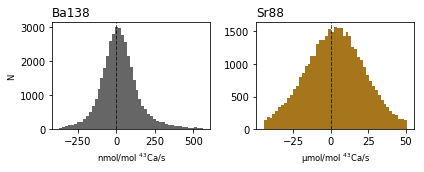

In [17]:
dat.gradient_histogram(['Ba138', 'Sr88'], win=21)

The high and low tails of these histograms represent the variable regions of the data, and we can see that reasonable thresholds would be a Ba/Ca of ~230 nmol/mol/s, and Sr/Ca of ~50 umol/mol/s. Let's calculate these:

In [18]:
# calculate gradient thresholds (note all units are mol/mol in the data)
dat.filter_gradient_threshold('Ba138', 250e-9, win=21)
dat.filter_gradient_threshold('Sr88', 50e-6, win=21)

Threshold Filter: 100%|██████████| 52/52 [00:04<00:00, 11.26it/s]


Now we have a range of calculated filters, but none of them are active yet.

In [19]:
dat.filter_status()

Subset: All Samples

n  Filter Name            Mg24   Mg25   Al27   Ca43   Ca44   Mn55   Sr88   Ba138  
0  Al27_thresh_below      False  False  False  False  False  False  False  False  
1  Al27_thresh_above      False  False  False  False  False  False  False  False  
2  Mn55_thresh_below      False  False  False  False  False  False  False  False  
3  Mn55_thresh_above      False  False  False  False  False  False  False  False  
4  Ba138_thresh_below     False  False  False  False  False  False  False  False  
5  Ba138_thresh_above     False  False  False  False  False  False  False  False  
6  Ba138_gthresh_below    False  False  False  False  False  False  False  False  
7  Ba138_gthresh_above    False  False  False  False  False  False  False  False  
8  Sr88_gthresh_below     False  False  False  False  False  False  False  False  
9  Sr88_gthresh_above     False  False  False  False  False  False  False  False  



### Creating Useful Filters

Threshold filters alone can be inherently 'fragmented' - i.e. if a region of data oscilates either side of the threshold value, this will produce lots of filter 'fragments'. These aren't particularly useful, and we should remove them. These 'fragmented' regions can be either removed or excluded, using the `filter_defragment` function.

Threshold filters are also rather naive. For example, we know that in spot measurements that ablate into the sample there is a degree of signal mixing from the side walls of the ablation pit. Therefore, as soon as you hit a contaminant phase, there will be trace of this contaminant signal in all data collected after you've hit it. To get around this, we can exclude data thatare 'down-hole' of contaminant signals. We can do this using the `filter_exclude_downhole` function.

### Filter Selection
In these samples, there are two types of elements - those that we know whould be homogeneous (Ba, Sr, Mn, Al) and those that we are expecting to be heterogeneous (Mg). By looking at the trace plots, it's evident that the main source of Mg variability is natural heterogeneity, as there's relatively little correlation with the contaminant indicators (Mn, Al, Ba). Therefore, we're going to use different filter combinations for these types of elements.

For homogeneous-type elements, we'll apply all the filters, defragment, and exclude down-hole regions.|

In [20]:
# make a filter for contaminant-prone elements
dat.filter_defragment(7, filt='Al27_thresh_below & Mn55_thresh_below & Ba138_thresh_below & Ba138_gthresh_below & Sr88_gthresh_below')
dat.filter_exclude_downhole(5, '8_defrag_include_7')
# activate filter
dat.filter_on('9_downhole_excl_5', ['Ba138', 'Al27', 'Mn55'], show_status=True)

Subset: All Samples

n  Filter Name            Mg24   Mg25   Al27   Ca43   Ca44   Mn55   Sr88   Ba138  
0  Al27_thresh_below      False  False  False  False  False  False  False  False  
1  Al27_thresh_above      False  False  False  False  False  False  False  False  
2  Mn55_thresh_below      False  False  False  False  False  False  False  False  
3  Mn55_thresh_above      False  False  False  False  False  False  False  False  
4  Ba138_thresh_below     False  False  False  False  False  False  False  False  
5  Ba138_thresh_above     False  False  False  False  False  False  False  False  
6  Ba138_gthresh_below    False  False  False  False  False  False  False  False  
7  Ba138_gthresh_above    False  False  False  False  False  False  False  False  
8  Sr88_gthresh_below     False  False  False  False  False  False  False  False  
9  Sr88_gthresh_above     False  False  False  False  False  False  False  False  
10 defrag_include_7       False  False  False  False  False  False

For heterogeneous Mg, which seems to be relatively insensitive to the other 'contaminants', we're only going to exclude high Al/Ca regions, which is indicative of ablating through the test into the underlying Al-rich carbon tape they are mounted on.

In [21]:
# make a filter for Mg (less strict)
dat.filter_defragment(15, filt='Al27_thresh_below')
dat.filter_exclude_downhole(5, '12_defrag_include_15')
# # activate filter
dat.filter_on('13_exclude_downhole_5', ['Mg24', 'Mg25', 'Sr88'], show_status=True)

Subset: All Samples

n  Filter Name            Mg24   Mg25   Al27   Ca43   Ca44   Mn55   Sr88   Ba138  
0  Al27_thresh_below      False  False  False  False  False  False  False  False  
1  Al27_thresh_above      False  False  False  False  False  False  False  False  
2  Mn55_thresh_below      False  False  False  False  False  False  False  False  
3  Mn55_thresh_above      False  False  False  False  False  False  False  False  
4  Ba138_thresh_below     False  False  False  False  False  False  False  False  
5  Ba138_thresh_above     False  False  False  False  False  False  False  False  
6  Ba138_gthresh_below    False  False  False  False  False  False  False  False  
7  Ba138_gthresh_above    False  False  False  False  False  False  False  False  
8  Sr88_gthresh_below     False  False  False  False  False  False  False  False  
9  Sr88_gthresh_above     False  False  False  False  False  False  False  False  
10 defrag_include_7       False  False  False  False  False  False

We now have two filters, one active for the homogeneous elements, and one for the heterogeneous Mg/Ca. This will do a pretty good job of selecting appropriate data regions.

Let's check what the filters are actually doing:

In [22]:
dat.trace_plots([a for a in dat.analytes if 'Ca' not in a], filt=True)

Drawing Plots: 100%|██████████| 58/58 [00:14<00:00,  3.93it/s]


In these plots, data that are excluded by filters are greyed out.

The filters are doign a pretty good job, but there's still some variability in the Ba, which suggests some contaminant signals have not been removed.

To fix this, we can go one step further:

### Optimise Selection

Ba/Ca is particularly contaminant-prone in these samples. To remove these contaminants, we will optimise the data selection such that both the mean concentration and RSD of Ba/Ca is minimised. This should identify contaminant-free regions.

We apply this optimised selection to Ba/Ca, Al/Ca, Mn/Ca and Sr/Ca. Sr/Ca is not commonly treated as a contaminant-prone element. However, we know from culture work that 'pristine' Sr/Ca should be homogeneous through the test. Looking at the traces for these samples, Sr/Ca exhibits distinct variability, which tends to correlate with Ba/Ca, Mn/Ca and Al/Ca, and increase with ablation time. Thus, it seems that Sr/Ca is prone to contamination in these samples, and we will select it using our contaminant filter.

(This takes a few minutes to run.)

In [23]:
# Optimise Ba138 selection to minimise mean and rsd
dat.optimise_signal(['Ba138'], 9, x_bias=0.2)

Optimising: 100%|██████████| 52/52 [04:06<00:00,  4.74s/it]


A Few Problems:
412_7_1: Optmisation failed. No contiguous data regions longer than 9 points.
412_8_1: Optmisation failed. No contiguous data regions longer than 9 points.
412_8_2: Optmisation failed. No contiguous data regions longer than 9 points.
412_9_1: Optmisation failed. No contiguous data regions longer than 9 points.
412_11_2: Optmisation failed. No contiguous data regions longer than 9 points.
412_11_3: Optmisation failed. No contiguous data regions longer than 9 points.
412_17_3: Optmisation failed. No contiguous data regions longer than 9 points.
414_1_2: Optmisation failed. No contiguous data regions longer than 9 points.
414_12_1: Optmisation failed. No contiguous data regions longer than 9 points.
414_12_2: Optmisation failed. No contiguous data regions longer than 9 points.
414_12_3: Optmisation failed. No contiguous data regions longer than 9 points.
414_12_4: Optmisation failed. No contiguous data regions longer than 9 points.
414_13_4: Optmisation failed. No contigu

In [24]:
dat.optimisation_plots()

Drawing Plots:  65%|██████▌   | 34/52 [01:00<00:31,  1.76s/it]

Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=9, top=9.0


Drawing Plots: 100%|██████████| 52/52 [01:28<00:00,  1.69s/it]


In [25]:
dat.filter_on('optimise_Ba138', ['Ba138'], show_status=True)

Subset: All Samples

n  Filter Name            Mg24   Mg25   Al27   Ca43   Ca44   Mn55   Sr88   Ba138  
0  Al27_thresh_below      False  False  False  False  False  False  False  False  
1  Al27_thresh_above      False  False  False  False  False  False  False  False  
2  Mn55_thresh_below      False  False  False  False  False  False  False  False  
3  Mn55_thresh_above      False  False  False  False  False  False  False  False  
4  Ba138_thresh_below     False  False  False  False  False  False  False  False  
5  Ba138_thresh_above     False  False  False  False  False  False  False  False  
6  Ba138_gthresh_below    False  False  False  False  False  False  False  False  
7  Ba138_gthresh_above    False  False  False  False  False  False  False  False  
8  Sr88_gthresh_below     False  False  False  False  False  False  False  False  
9  Sr88_gthresh_above     False  False  False  False  False  False  False  False  
10 defrag_include_7       False  False  False  False  False  False

In [26]:
# dat.filter_status()

In [27]:
dat.sample_stats(stats=['mean'])

Calculating Stats: 100%|██████████| 58/58 [00:00<00:00, 211.81it/s]


In [28]:
ld = dat.getstats().loc['mean'] * 1e3

## Data Comparison

In [29]:
# load reference and test data
rd = helpers.load_reference_data('downcore_reference')
td = helpers.load_reference_data('downcore_test')

# combine all data
df = rd.join(td, lsuffix='_r', rsuffix='_t')
df = df.join(ld)

In [30]:
# number of unique samples
np.unique(rd.index.levels[0]).size

53

## Characterise inter-replicate reproducibility in Reference data

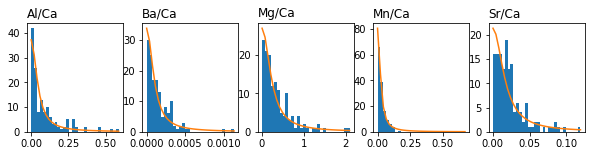

In [31]:
# in reference data
_, rep_dists, rep_stats, _ = stats.pairwise_reproducibility(rd, plot=True)

In [32]:
rep = pd.DataFrame(rep_stats).T
rep.columns = ['50%', '95%']
rep = rep.loc[['Mg/Ca', 'Sr/Ca', 'Ba/Ca', 'Al/Ca', 'Mn/Ca'],:]

In [33]:
rep.to_csv('reproducibility_quants.csv')

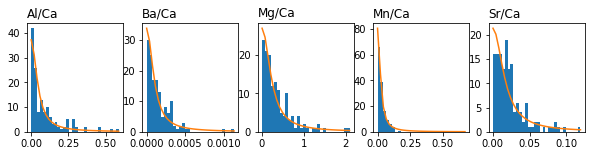

In [34]:
# in test data
_ = stats.pairwise_reproducibility(rd, plot=True)

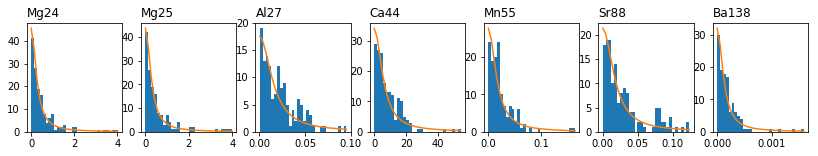

In [35]:
# in latools data
_ = stats.pairwise_reproducibility(ld, plot=True)

## Compare Data

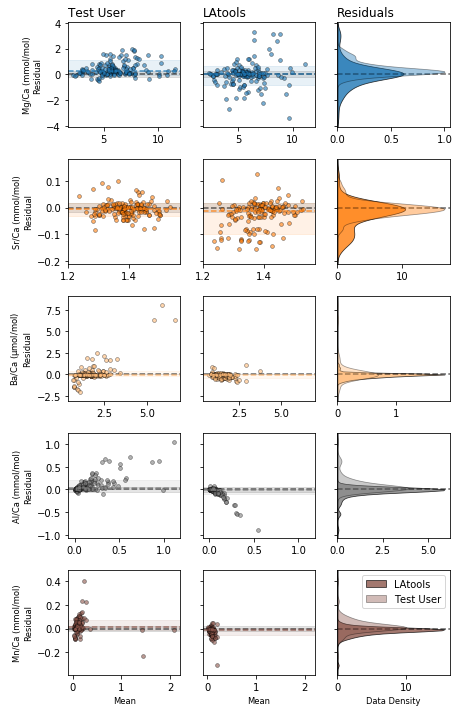

In [36]:
fig, axs = plots.bland_altman_plots(df, rep_stats)

fig.savefig('Figures/downcore_comparison.pdf')
fig.savefig('Figures/downcore_comparison.png', dpi=200)

In [37]:
# fig, axs = plots.comparison_plots(df)

In [38]:
# fig, axs = plots.residual_plots(df, rep_stats)

## Comparison Statistics

In [39]:
stat = stats.comparison_stats(df)

In [40]:
stat.to_csv('Stats/downcore_stats.csv')

In [41]:
stat['Test User']

Residual Summary                                                 \
                     N      Median          LQ        IQR          UQ   
Mg/Ca              149    0.278483   0.0947975   0.499073    0.593871   
Sr/Ca              149 -0.00562857  -0.0196323  0.0266532  0.00702097   
Ba/Ca              149   -0.072966   -0.106512   0.189704   0.0831927   
Al/Ca              149   0.0336077  0.00764255   0.107416    0.115058   
Mn/Ca              149   0.0107187 -0.00044312  0.0384314   0.0379883   

      Residual Regression                                               \
                    Slope  Slope t      Slope p  Intercept Intercept t   
Mg/Ca           0.0273585  1.20041     0.231912   0.260619     1.87873   
Sr/Ca            -0.12196 -3.39093   0.00089479   0.164621     3.28086   
Ba/Ca            0.375683  2.07146    0.0400641  -0.465135    -1.50099   
Al/Ca            0.411013  4.54974  1.11622e-05  0.0554501     3.40844   
Mn/Ca          -0.0649723  -3.1429   0.00202379  0.0289588     5.34251   

                               Kolmogorov-Smirnov               
       Intercept p          R2                 KS            p  
Mg/Ca    0.0622613  0.00970743           0.167785    0.0264765  
Sr/Ca   0.00129257    0.072546           0.127517     0.164421  
Ba/Ca     0.135503   0.0283621          0.0939597      0.50647  
Al/Ca  0.000843259    0.123435           0.248322  0.000153847  
Mn/Ca  3.41845e-07   0.0629651           0.228188  0.000671689

In [42]:
stat['LAtools']

Residual Summary                                                \
                     N      Median         LQ        IQR          UQ   
Mg/Ca              140   0.0351984  -0.269019   0.547434    0.278414   
Sr/Ca              140  -0.0123943 -0.0446158  0.0476549  0.00303906   
Ba/Ca              122  -0.0479015  -0.260919   0.304336    0.043417   
Al/Ca              133 -0.00298329  -0.035042  0.0438025  0.00876049   
Mn/Ca              133  -0.0126693 -0.0329672  0.0297417 -0.00322552   

      Residual Regression                                               \
                    Slope  Slope t      Slope p  Intercept Intercept t   
Mg/Ca          -0.0740551 -1.60986     0.109713   0.426056     1.54525   
Sr/Ca          -0.0730251    -1.07     0.286486  0.0747704    0.783876   
Ba/Ca            -0.24584  -5.2019  8.23564e-07   0.276395     3.53978   
Al/Ca           -0.894363 -58.0211  2.60752e-95  0.0356573     13.9829   
Mn/Ca           -0.570222  -12.162  3.02278e-23  0.0282698     6.08107   

                               Kolmogorov-Smirnov               
       Intercept p          R2                 KS            p  
Mg/Ca     0.124577    0.018434               0.05     0.993629  
Sr/Ca     0.434456  0.00822815           0.185714    0.0137004  
Ba/Ca  0.000570776    0.184005           0.139344     0.172324  
Al/Ca  9.37095e-28    0.962544           0.233083   0.00114665  
Mn/Ca  1.22246e-08     0.53032           0.278195  4.82153e-05